<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Общие-сведения" data-toc-modified-id="Общие-сведения-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Общие сведения</a></span></li><li><span><a href="#Анализ-датасета" data-toc-modified-id="Анализ-датасета-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ датасета</a></span></li><li><span><a href="#Препроцессинг" data-toc-modified-id="Препроцессинг-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Препроцессинг</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Random forest</a></span></li><li><span><a href="#LGBoost" data-toc-modified-id="LGBoost-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBoost</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#Сравнение-с-случайной-моделью-и-константной" data-toc-modified-id="Сравнение-с-случайной-моделью-и-константной-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Сравнение с случайной моделью и константной</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Прогнозирование оттока клиентов банка

*Менеджер банка обеспокоен тем, что все больше и больше клиентов отказываются от обслуживания кредитных карт. Он был бы очень признателен, если бы кто-то мог предсказать кто скоро откажется от услуг, чтобы работники могли заранее обратиться к клиентам, чтобы предоставить им более качественные услуги и изменить их решения в противоположном направлении.*

Данные взяты с [kaggle](https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers), вот их краткое описание:
* CLIENTNUM - Client number. Unique identifier for the customer holding the account

* Attrition_Flag - Internal event (customer activity) variable - if the account is closed then 1 else 0

* Customer_Age - Demographic variable - Customer's Age in Years

* Gender - Demographic variable - M=Male, F=Female

* Dependent_count - Demographic variable - Number of dependents

* Education_Level - Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)

* Marital_Status - Demographic variable - Married, Single, Divorced, Unknown

* Income_Category - Demographic variable - Annual Income Category of the account holder (< 40K, 40K - 60K, 60K - 80K, 80K-120K, > 120K, Unknown)

* Card_Category - Product Variable - Type of Card (Blue, Silver, Gold, Platinum)

* Months_on_book - Period of relationship with bank

* Total_Relationship_Count - Total no. of products held by the customer

* Months_Inactive_12_mon - No. of months inactive in the last 12 months

* Contacts_Count_12_mon - No. of Contacts in the last 12 months

* Credit_Limit - Credit Limit on the Credit Card

* Total_Revolving_Bal - Total Revolving Balance on the Credit Card

* Avg_Open_To_Buy - Open to Buy Credit Line (Average of last 12 months)

* Total_Amt_Chng_Q4_Q1 - Change in Transaction Amount (Q4 over Q1)

* Total_Trans_Amt - Total Transaction Amount (Last 12 months)

* Total_Trans_Ct - Total Transaction Count (Last 12 months)

* Total_Ct_Chng_Q4_Q1 - Change in Transaction Count (Q4 over Q1)

* Avg_Utilization_Ratio - Average Card Utilization Ratio

## Общие сведения

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import phik

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve, plot_roc_curve

from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('BankChurners.csv')
df = df[df.columns[:-2]]

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   clientnum                 10127 non-null  int64  
 1   attrition_flag            10127 non-null  object 
 2   customer_age              10127 non-null  int64  
 3   gender                    10127 non-null  object 
 4   dependent_count           10127 non-null  int64  
 5   education_level           10127 non-null  object 
 6   marital_status            10127 non-null  object 
 7   income_category           10127 non-null  object 
 8   card_category             10127 non-null  object 
 9   months_on_book            10127 non-null  int64  
 10  total_relationship_count  10127 non-null  int64  
 11  months_inactive_12_mon    10127 non-null  int64  
 12  contacts_count_12_mon     10127 non-null  int64  
 13  credit_limit              10127 non-null  float64
 14  total_

Данные содержат 10127 объектов без пропусков, этого должно быть достаточно для обучения простых деревянных моделей даже без удаления лишних фичей

## Анализ датасета

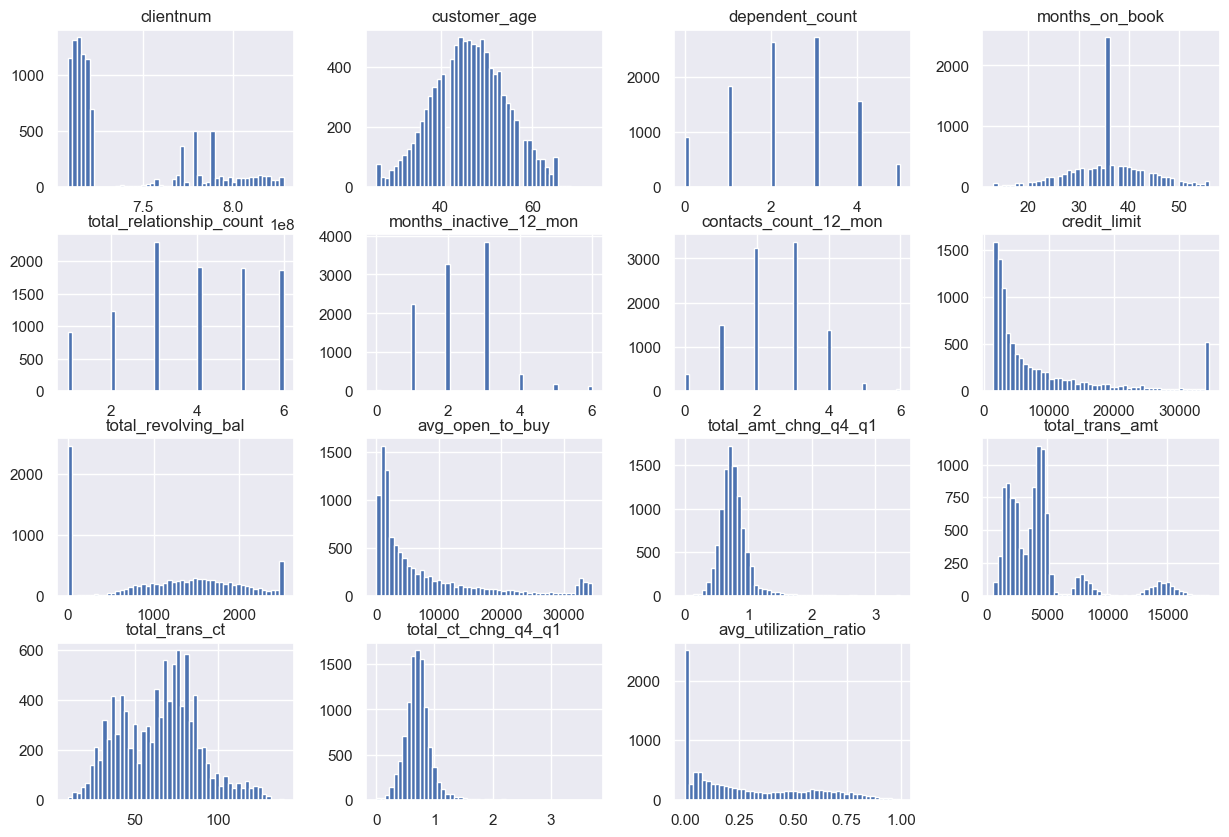

In [6]:
df.hist(figsize=(15,10), bins=50);

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
clientnum,10127.0,7.391776e+08,3.690378e+07,708082083.0,7.130368e+08,7.179264e+08,7.731435e+08,8.283431e+08
customer_age,10127.0,4.632596e+01,8.016814e+00,26.0,4.100000e+01,4.600000e+01,5.200000e+01,7.300000e+01
dependent_count,10127.0,2.346203e+00,1.298908e+00,0.0,1.000000e+00,2.000000e+00,3.000000e+00,5.000000e+00
months_on_book,10127.0,3.592841e+01,7.986416e+00,13.0,3.100000e+01,3.600000e+01,4.000000e+01,5.600000e+01
total_relationship_count,10127.0,3.812580e+00,1.554408e+00,1.0,3.000000e+00,4.000000e+00,5.000000e+00,6.000000e+00
months_inactive_12_mon,10127.0,2.341167e+00,1.010622e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
contacts_count_12_mon,10127.0,2.455317e+00,1.106225e+00,0.0,2.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00
credit_limit,10127.0,8.631954e+03,9.088777e+03,1438.3,2.555000e+03,4.549000e+03,1.106750e+04,3.451600e+04
total_revolving_bal,10127.0,1.162814e+03,8.149873e+02,0.0,3.590000e+02,1.276000e+03,1.784000e+03,2.517000e+03
avg_open_to_buy,10127.0,7.469140e+03,9.090685e+03,3.0,1.324500e+03,3.474000e+03,9.859000e+03,3.451600e+04


Данные во многом имеют распределение близкое к нормальному, однако есть бросающиеся в глаза особенности:
* В данных months_on_book имеется неожиданный пик на 36, о природе можно только догадываться.
* В столбце credit_limit имеется множество клиентов с максимально разрешенным кредитным лимитом на карточке
* В столбце total_trans_amt отчетливо видно наложение 4 категорий клиентов, может быть полезно выяснить причину такой картины, например для сегментации клиентов и проведения таргетированной рекламы

In [8]:
def plot_pie(column):  # Функция для быстрой постройки круговых диагамм
    (df.pivot_table(values=['clientnum'], index=column, aggfunc='count')
        .plot(kind='pie', subplots=True, figsize=(5, 5), autopct='%1.2f%%')
    )
    plt.ylabel('');

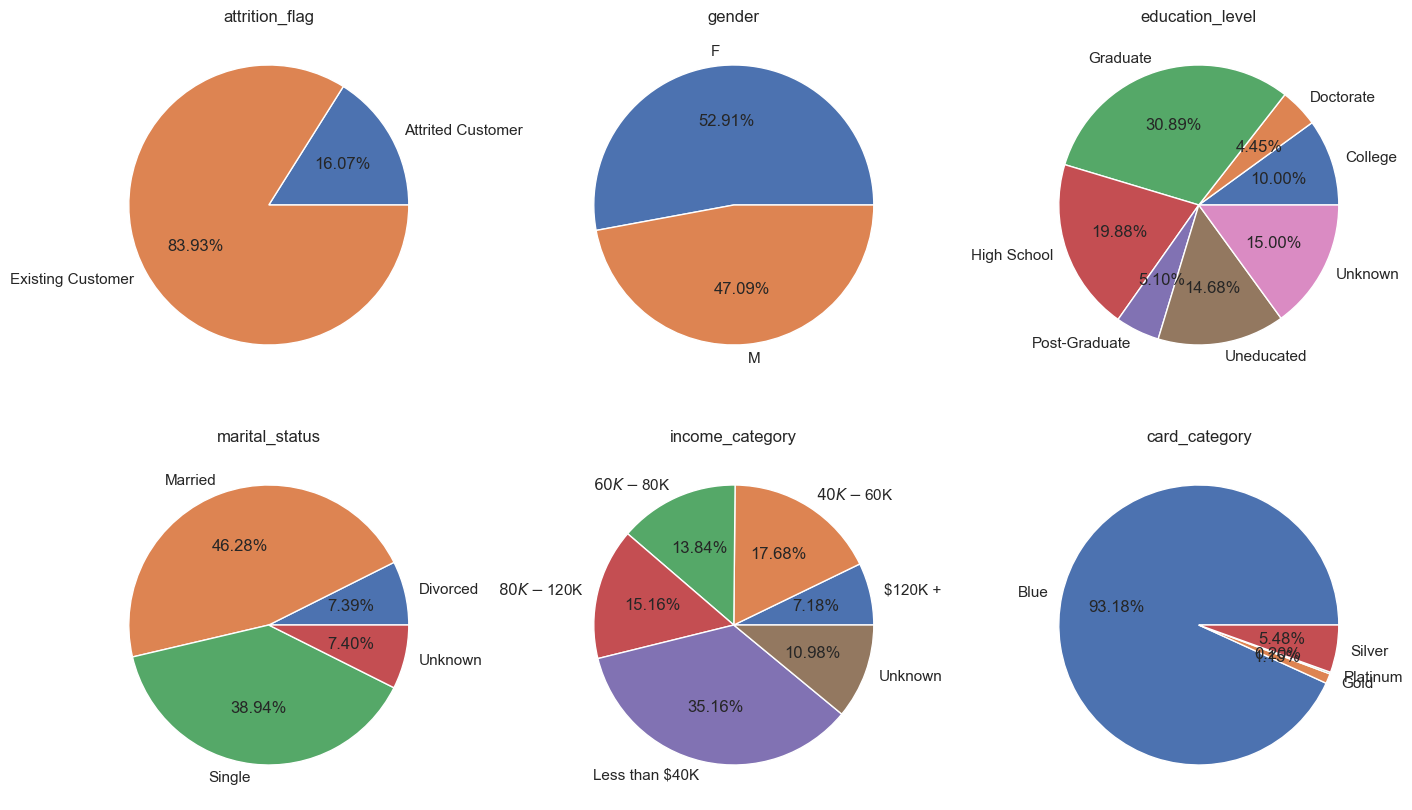

In [9]:
i = 1
for col in df:
    if df[col].dtype != 'O':
        continue
    plt.subplot(2, 3, i)
    df_n = df.pivot_table(values=['clientnum'], index=col, aggfunc='count')
    plt.pie(
        df_n['clientnum'],
        autopct='%1.2f%%', labels=df_n.index);
    plt.title(col)
    i+=1
plt.gcf().set_size_inches(17,10);

Определяемый параметр attrition_flag сильно не сбалансирован, в дальнейшем проведем upsampling. В остальном данные нормальные, можно дополнительно отметить подавляющую категорию обладателей синих карт - не премиальных пользователей

*Посмотрим повнимательнее на total_trans_amt*

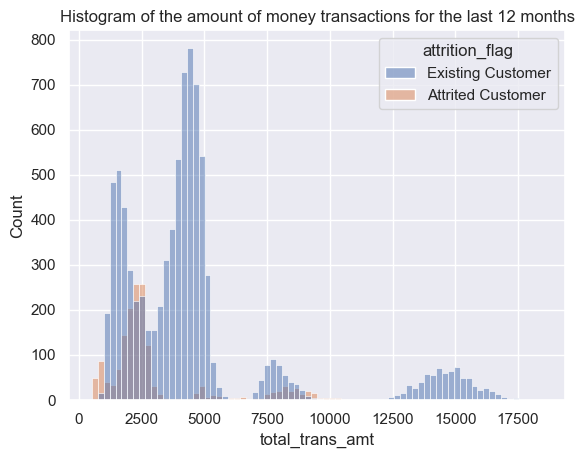

In [10]:
sns.histplot(df, x='total_trans_amt', hue='attrition_flag')
plt.title('Histogram of the amount of money transactions for the last 12 months');

Из хороших новостей - практически не уходят клиенты которые потратили за последний год более 10000, значит банк пока не потеряет премиальных клиентов. 

## Препроцессинг

Перекодируем целевой параметр attrition_flag, остальные категориальные параметры будут автоматически перекодироваться OHE в пайплайне, а числовые приводится к нормальному виду

In [11]:
df['attrition_flag'] = df['attrition_flag'].replace({'Attrited Customer':1,'Existing Customer':0})

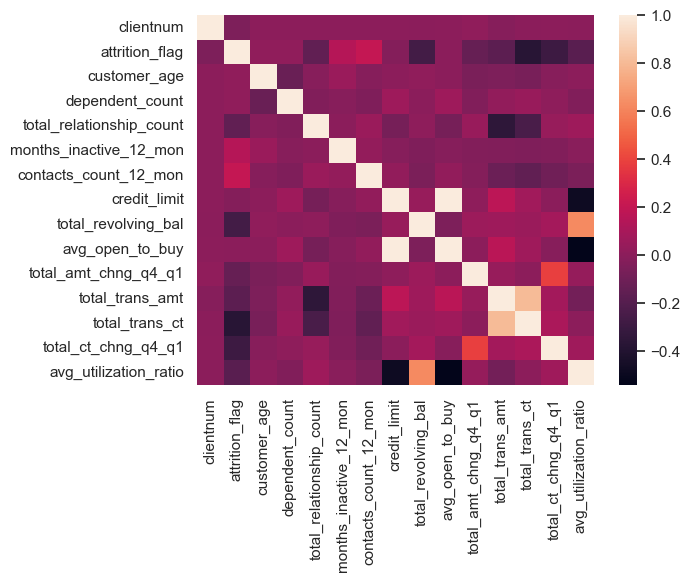

In [12]:
sns.heatmap((
    df.drop(columns=['gender', 'education_level', 'marital_status', 'income_category', 'card_category', 'months_on_book'])
).corr());

Сильных линейных корреляций с целевым признаком нет

interval columns not set, guessing: ['clientnum', 'attrition_flag', 'customer_age', 'dependent_count', 'months_on_book', 'total_relationship_count', 'months_inactive_12_mon', 'contacts_count_12_mon', 'credit_limit', 'total_revolving_bal', 'avg_open_to_buy', 'total_amt_chng_q4_q1', 'total_trans_amt', 'total_trans_ct', 'total_ct_chng_q4_q1', 'avg_utilization_ratio']


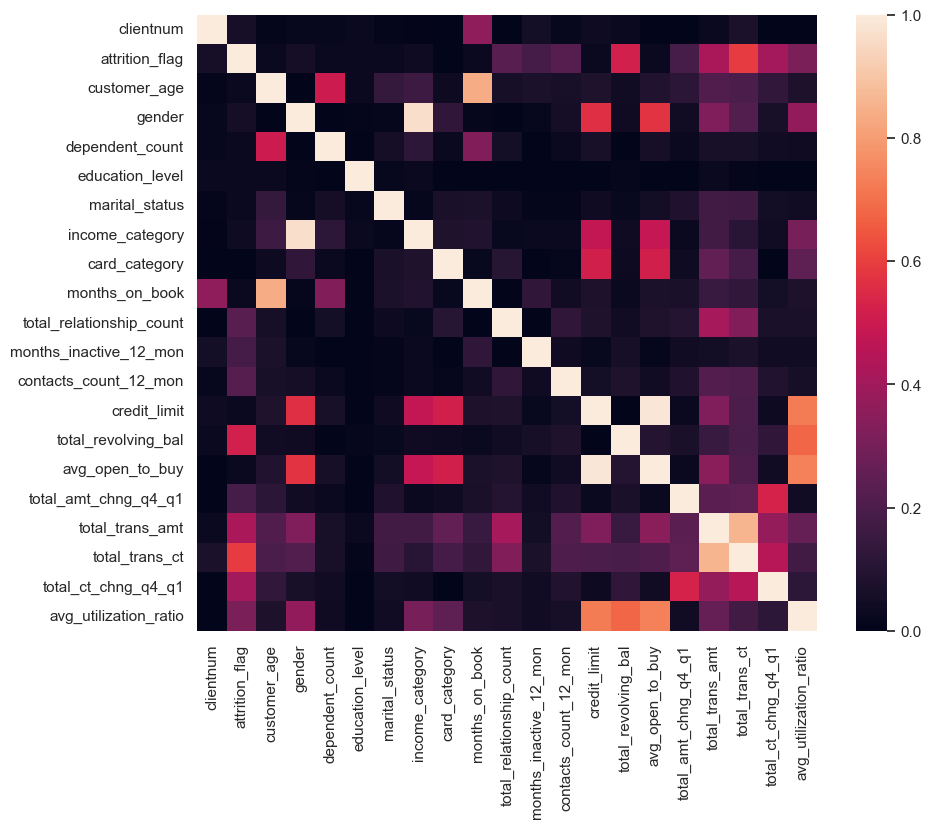

In [13]:
sns.heatmap(df.phik_matrix())
plt.gcf().set_size_inches(10,8);

Корреляция фика указывает на несколько более сильные связи - будем обучать деревянные модели. Пока удалять лишние слабо коррелирующие признаки не будем

In [14]:
df.drop(columns=('clientnum'), inplace=True)

In [15]:
X_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['attrition_flag']), df['attrition_flag'],
                                                    test_size=0.25, random_state=42)

In [16]:
categorical_columns = [df.columns[i] for i, col in enumerate(df) if df[col].dtype == 'O']
numerical_columns = [df.columns[i] for i, col in enumerate(df) if df[col].dtype != 'O' and col != 'attrition_flag']

## Обучение моделей

Будем обучать модели случайного леса и градиентного бустинга. На вход будем подавать сырые данные, а пайплайн с OHE и StandardScaler будет их обрабатывать конвеерно. Чтобы автоматически производить ресемплинг, в пайплайн добавим SMOTE. Чтобы это все работало корректно, pipeline используется из библиотеки imblearn. В качестве метрики качества используем f1

In [17]:
categorical_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('ordinal_encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)],
    n_jobs=-1
)

### Random forest

In [18]:
pipe = Pipeline([('pre', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', RandomForestClassifier())])

grid={
    'clf__max_depth':list(np.arange(3, 60, step=3)),
    'clf__n_estimators':np.arange(10, 300, step=10),
    'clf__max_features':np.arange(1, 7),
    'clf__min_samples_leaf':np.arange(1, 4),
    'clf__min_samples_split':np.arange(2, 10, step=2)
}


In [19]:
random_forest_model = RandomizedSearchCV(pipe, grid, n_iter=25, cv=5, scoring='f1', n_jobs=-1, random_state=42)
random_forest_model.fit(X_train, y_train);

In [20]:
random_forest_model.best_params_

{'clf__n_estimators': 160,
 'clf__min_samples_split': 2,
 'clf__min_samples_leaf': 1,
 'clf__max_features': 5,
 'clf__max_depth': 24}

In [21]:
random_forest_model.best_score_

0.8783197104825632

### LGBoost

In [22]:
pipe = Pipeline([('pre', preprocessor), ('smote', SMOTE(random_state=42)), ('clf', LGBMClassifier())])

grid={
    'clf__max_depth':[2, 4, 6],
    'clf__learning_rate': [0.1, 0.2, 0.3],
    'clf__n_estimators':[100, 200, 300, 400]
}

lgboost_model = GridSearchCV(pipe, grid, cv=5, scoring='f1', n_jobs=-1)
lgboost_model.fit(X_train, y_train);

In [23]:
lgboost_model.best_params_

{'clf__learning_rate': 0.3, 'clf__max_depth': 4, 'clf__n_estimators': 400}

In [24]:
lgboost_model.best_score_

0.9241749167507404

Модель LGBoost показывает себя несколько лучше - тестировать будем ее

## Тестирование модели

In [25]:
y_pred = lgboost_model.predict(x_test)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precisison:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

accuracy: 0.9680094786729858
precisison: 0.9043062200956937
recall: 0.9021479713603818
F1: 0.903225806451613


Модель показывает хорошую точность и f1, не смотря на то что в тестовых данных сильный дисбаланс

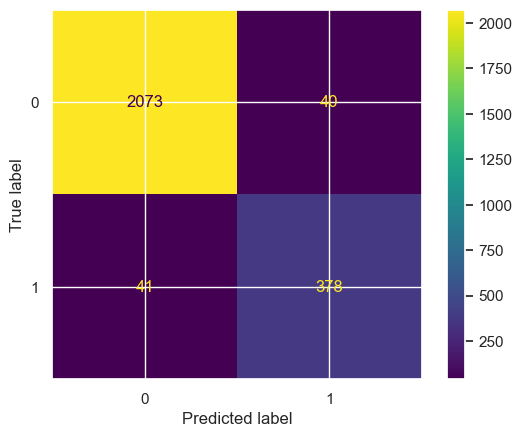

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=lgboost_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lgboost_model.classes_)
disp.plot()
plt.show()

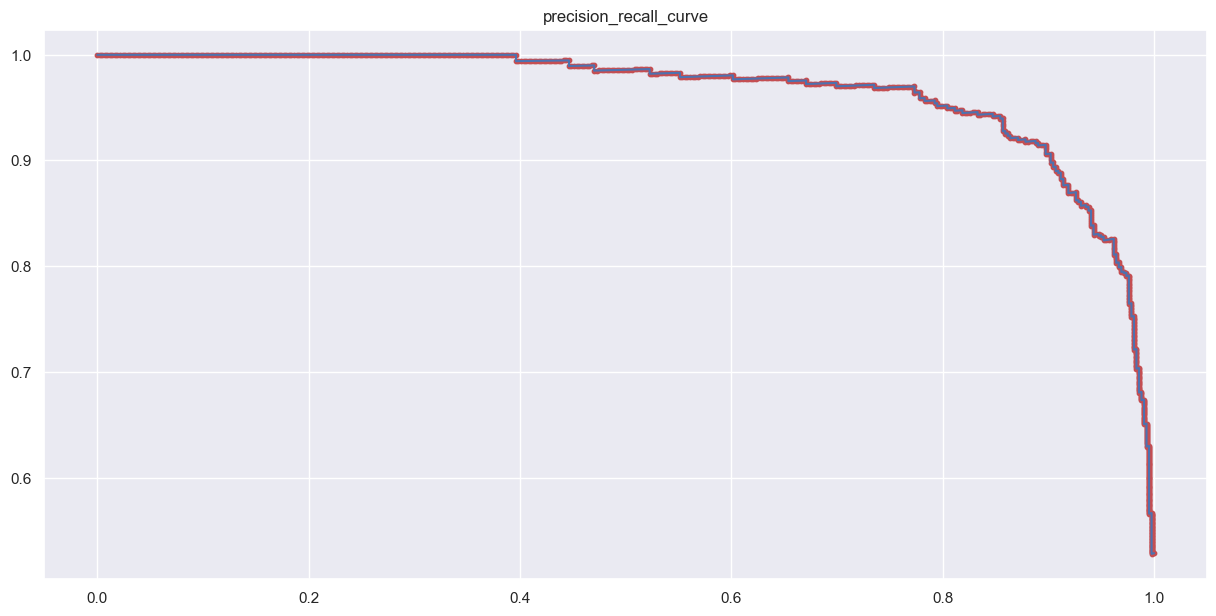

In [27]:
probas = lgboost_model.predict_proba(x_test)[:,1]
precision,recall,thresholds = precision_recall_curve(y_test, probas)

plt.figure(figsize=(15,12))
plt.plot(recall, precision)
plt.scatter(recall, precision, c='r', s=10)
plt.gca().set_aspect('equal')
plt.title('precision_recall_curve')
plt.show()

C:\Users\Home\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'roc_curve')

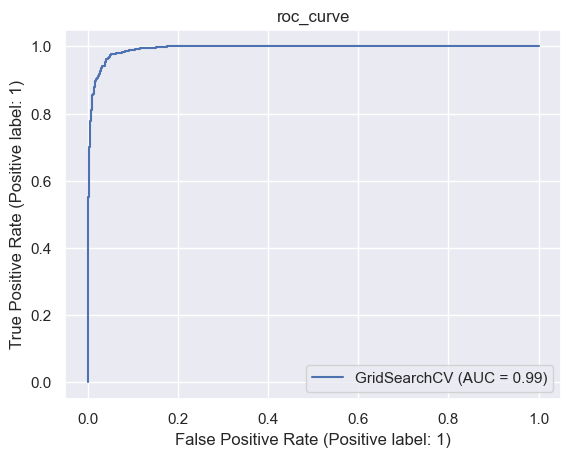

In [28]:
plot_roc_curve(lgboost_model, x_test, y_test)
plt.title('roc_curve')

In [29]:
print('roc_auc:', roc_auc_score(y_test, y_pred))

roc_auc: 0.941608770346542


roc кривая сильно стремится в левый верхний угол, значит она хорошо разделяет два наших класса, значит, в дальнейшем, можно будет упорядочить клиентов по вероятности ухода и обрабатывать наиболее вероятно уходящих. Чтобы оценить порог для обработки клиента необходимы дополнительные данные о планируемых затратах на удерживание и вероятных издержках следуемых из-за ухода клиента

### Сравнение с случайной моделью и константной

In [30]:
y_pred = np.zeros_like(y_pred)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precisison:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

accuracy: 0.834518167456556
precisison: 0.0
recall: 0.0
F1: 0.0


C:\Users\Home\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
y_pred = shuffle(y_test, random_state=42)
print('accuracy:', accuracy_score(y_test, y_pred))
print('precisison:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))

accuracy: 0.7243285939968405
precisison: 0.16706443914081145
recall: 0.16706443914081145
F1: 0.16706443914081145


Модель проявляет себя гораздо лучше случайной и константной, а значит модель адекватна

## Вывод

**Исследован и обработан датасет**
* В данных months_on_book имеется неожиданный пик на 36, возможно это сбой, стоит проверить сбор данных в базу
* В столбце total_trans_amt(сумма транзакций за 12 мес) отчетливо видно наложение 4 категорий клиентов, может быть полезно выяснить причину такой картины, например для сегментации клиентов и проведения таргетированной рекламы

**Обучены модели предсказания ухода клиента**

*Обучение производилось моделей случайного леса и градиентного бустинга с перебором гиперпараметров. На вход пайплайну с OHE, StandardScaler, и ресемплингом SMOTE подавались сырые данные. В качестве метрики качества используется f1*
* Наилучшим образом проявила себя модель lgboost('learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 400), f1 = 0.90 на тестовой выборке.

* В дальнейшем, необходимо будет упорядочить клиентов по вероятности ухода и обрабатывать наиболее вероятно уходящих. Чтобы оценить порог для обработки клиента необходимы дополнительные данные о планируемых затратах на удерживание и издержки следуемые из ухода клиента.